# Exploratory Data Analysis

In [1]:
import os
import sys
import random
import shutil
import pandas as pd
import xml.etree.ElementTree as ET
import pickle

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Summary

- Each of the 300k files in the dataset is an XML. 
- Each XML is organized in a tree format, with text on the leaf nodes
- The trees are not the same for each file, but many branches and leaves are shared
- Across all of the files, there are 252 unique leaf nodes of 2 types:
    - unique to the document: each document has a maximum of 1 of these nodes. For example ./brief_title (103/252)
    - multiple per document; each document has none, 1, or many of these nodes. For example ./keyword (149/252)

- I've created a sample of 1000 files in './raw_data/sample/ for use for testing crawling routines faster
- For the entire dataset I've created a field summary file under 'rf_data/summary.csv' with the following columns:
    - total_count: total occurance of that node in all files
    - file_count: number of files containing that node
    - unique_per_file: true if max node count / file = 1 across all files
    - level: node's position measured in levels down the root of the tree
    - avg_per_file: total_count / file_count
    - pct_files: file_count / total num files
    - ex1 - ex5: 5 examples randomly sampled texts in this node from all files
    
- For the entire set of sample files, I've measured the occurance of text in each node. 
- For example, out of 1000 files in the ./source node:
    - National Institutes of Health Clinical Center (CC) occured 20x
    - Novartis occured 15x
    - GlaxoSmithKline occured 10x
- Another example in the ./study_type node:
    - Interventional occured 796x
    - Observational occured 185x
    - Observational [Patient Registry] occured 19x

# Results

In [217]:
# loading all pickled results

node2file_sample = pickle.load(open('rf_data/node2file_sample.p', 'rb'))
node2file = pickle.load(open('rf_data/node2file.p', 'rb'))
dfj = pd.read_csv('rf_data/summary.csv', index_col='node')
sum_df_dict = pickle.load(open('rf_data/summary_dfs.p', 'rb'))

### summary statistics about each node

In [225]:
dfj

,total_count,file_count,unique_per_file,level,avg_per_file,pct_files,ex1,ex2,ex3,ex4,ex5
node,,,,,,,,,,,
./required_header/download_date,316464,316464,True,2,1.000000,1.000000,ClinicalTrials.gov processed this data on Sept...,ClinicalTrials.gov processed this data on Sept...,ClinicalTrials.gov processed this data on Sept...,ClinicalTrials.gov processed this data on Sept...,ClinicalTrials.gov processed this data on Sept...
./required_header/link_text,316464,316464,True,2,1.000000,1.000000,Link to the current ClinicalTrials.gov record.,Link to the current ClinicalTrials.gov record.,Link to the current ClinicalTrials.gov record.,Link to the current ClinicalTrials.gov record.,Link to the current ClinicalTrials.gov record.
./required_header/url,316464,316464,True,2,1.000000,1.000000,https://clinicaltrials.gov/show/NCT01575444,https://clinicaltrials.gov/show/NCT02491242,https://clinicaltrials.gov/show/NCT02307513,https://clinicaltrials.gov/show/NCT03993132,https://clinicaltrials.gov/show/NCT03392870
./id_info/org_study_id,316434,316434,True,2,1.000000,0.999905,CLEVER-2011,2017-08-124-C,940597,R01AT001146-01,Rad 2:5:1
./id_info/secondary_id,115345,74853,False,2,1.540954,0.236529,CDR0000398140,2014-000218-67,ID-RCB 2007-A01326-47,SPARROW-I071-341-03,E-6200
...,...,...,...,...,...,...,...,...,...,...,...
./clinical_results/outcome_list/outcome/analysis_list/analysis/other_analysis_desc,780,205,False,6,3.804878,0.000648,The direction of comparison is currently worki...,The null hypothesis was that we could further ...,Superiority would be declared if the lower end...,A dose level for RAD001 will be considered acc...,The PK parameters were compared between treatm...
./clinical_results/baseline/measure_list/measure/analyzed_list/analyzed/units,458,29,False,7,15.793103,0.000092,Vessels,Participants,Sites,Participants,Participants
./clinical_results/baseline/measure_list/measure/analyzed_list/analyzed/scope,458,29,False,7,15.793103,0.000092,Measure,Measure,Measure,Measure,Measure


### Distribution of node coverage

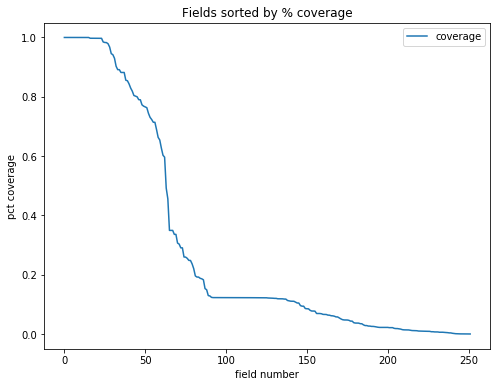

In [226]:
plt.figure(figsize=(8,6))
plt.plot(dfj['pct_files'].sort_values(ascending=False).values, label='coverage')
plt.title('Fields sorted by % coverage')
plt.xlabel('field number')
plt.ylabel('pct coverage')
plt.legend()
plt.show()

### Commonly occuring texts by node

In [232]:
sum_df_dict['./study_type'].head(10)

,count
text,
Interventional,796
Observational,185
Observational [Patient Registry],19


In [231]:
sum_df_dict['./source'].head(10)

,count
text,
National Institutes of Health Clinical Center (CC),20
Novartis,15
GlaxoSmithKline,12
National Cancer Institute (NCI),11
M.D. Anderson Cancer Center,10
Boehringer Ingelheim,9
Assistance Publique - Hôpitaux de Paris,8
Memorial Sloan Kettering Cancer Center,8
VA Office of Research and Development,8


### Distribution of node coverage by node depth

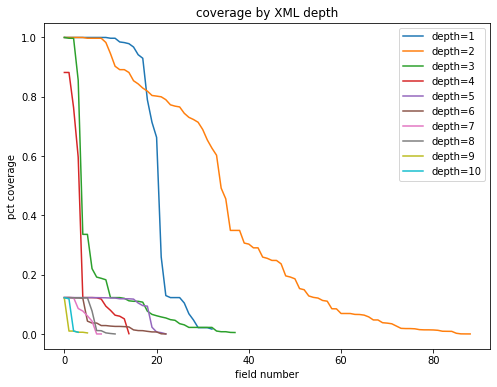

In [229]:
plt.figure(figsize=(8, 6))
plt.title('coverage by XML depth')
for cur_lvl in sorted(dfj['level'].unique()):
    sub_df = dfj[dfj['level'] == cur_lvl]
    plt.plot(sub_df['pct_files'].sort_values(ascending=False).values, label='depth='+str(cur_lvl))
plt.legend()
plt.xlabel('field number')
plt.ylabel('pct coverage')
plt.show()

# Work

In [19]:
sample_path = '../raw_data/sample/'
all_path = '../raw_data/all/'

## 1. Sampling

we will sample 1000 files from the 300k+ files as a subset on which to experiment algorithms

In [8]:
def get_sample_filepaths(all_dir, target_num=1000):
    all_n_folders = os.listdir(all_dir)
    
    # compute how many to sample from each folder
    num_folders = len(all_n_folders)
    num_to_sample = target_num // num_folders + 1
    
    # sampling
    all_sampled = []
    for cur_n_folder in tqdm(all_n_folders):
        cur_files = os.listdir(all_dir + cur_n_folder)
        cur_rand = random.choices(cur_files, k=num_to_sample)
        
        # adding sampled to the final list
        for fn in cur_rand:
            all_sampled.append(cur_n_folder + '/' + fn)
            
    if len(all_sampled) > target_num:
        return all_sampled[:target_num]
    else:
        return all_sampled
    

def cp_sampled_files(all_sampled_paths, all_path, sample_path):
    for cur_path in tqdm(all_sampled_paths):
        needed_dir = cur_path.split('/')[0]
        if not os.path.exists(sample_path + needed_dir + '/'):
            os.mkdir(sample_path + needed_dir)
        shutil.copy(all_path + cur_path, sample_path + cur_path)

In [21]:
all_sampled_paths = get_sample_filepaths(all_path)
cp_sampled_files(all_sampled_paths, all_path, sample_path)

### Making sure we can read 1 file in the sampled path

In [26]:
test_file = '../raw_data/sample/NCT0000xxxx/NCT00005042.xml'

In [27]:
tree = ET.parse(test_file)
root = tree.getroot()

In [28]:
root.findtext('./id_info/nct_id')

'NCT00005042'

# File iterator generation

Methods for generating an iteration to loop through all of the XML files given a docroot

In [35]:
def gen_files(root_path, req_exts='xml'):
    """ builds the generator for all files that match a specified extension in root """
    # handling a non-list req_ext input
    if isinstance(req_exts, str):
        req_exts = [req_exts]
        
    # iterator
    for subdirs, dirs, files in os.walk(root_path):
        for file in files:
            # check the extensions
            if req_exts is not None:
                cur_ext = file.split('.')[-1]
                if cur_ext in req_exts:
                    yield os.path.join(subdirs, file)
            else:
                yield os.path.join(subdirs, file)
    
def list_files(root_path, req_exts='xml'):
    """ wraps the generator to get the list instead """
    return list(gen_files(root_path, req_exts=req_exts))

In [36]:
all_fps = list_files(sample_path)

## XML crawling

Methods for obtaining the list of all nodes (or leaves) in the tree starting with a XML root

In [43]:
def crawl_tree_tags(root, leaf_only=False):
    """ returns list of all nodes, or leaves """
    all_nodes = []
    for c in root:
        all_nodes += crawl_child_tags(c, leaf_only=leaf_only)
    return all_nodes

def crawl_child_tags(node, leaf_only=False, parent_path='./'):
    """ recursively cralws all children and their children etc ... """
    all_nodes = []
    if not leaf_only or len(node) == 0:
        all_nodes += [parent_path + node.tag]
        
    for c in node:
        all_nodes += crawl_child_tags(c, leaf_only=leaf_only, parent_path=parent_path + node.tag + '/')
        
    return all_nodes

### Trying out the method

In [44]:
all_nodes = crawl_tree_tags(root, leaf_only=True)
len(all_nodes)

60

In [45]:
all_nodes[:10]

['./required_header/download_date',
 './required_header/link_text',
 './required_header/url',
 './id_info/org_study_id',
 './id_info/secondary_id',
 './id_info/nct_id',
 './id_info/nct_alias',
 './brief_title',
 './official_title',
 './sponsors/lead_sponsor/agency']

In [46]:
all_nodes = crawl_tree_tags(root, leaf_only=False)
len(all_nodes)

83

In [47]:
all_nodes[:10]

['./required_header',
 './required_header/download_date',
 './required_header/link_text',
 './required_header/url',
 './id_info',
 './id_info/org_study_id',
 './id_info/secondary_id',
 './id_info/nct_id',
 './id_info/nct_alias',
 './brief_title']

# Crawling files for summary stats and for the node2file dict

In [146]:
def crawl_files(root_path, leaf_only=True):
    """
    crawls all of the xml files in the roo dir and counts the type of nodes in each
    builds the dictionary that helps us go from node name to list of files, 
    used in further investigating specific nodes
    """
    column_names = ['total_count', 'file_count', 'unique_per_file']
    all_fps = list_files(root_path, req_exts='xml')
    node_dict = {}  # for building summary dataframe
    node2file = {}  # for building the node to file list dictionary
    error_files = []
    
    for fp in tqdm(all_fps):
        try:
            # tracks which nodes has already been processed
            cur_file_nodes = []

            # parsing the xml
            tree = ET.parse(fp)
            root = tree.getroot()
            all_nodes = crawl_tree_tags(root, leaf_only=leaf_only)

            # looping throuhg all of the nodes and process both dictionaries
            for cur_node in all_nodes:             
                # check if first time seeing this node:
                if cur_node in cur_file_nodes:
                    first_time = False
                else:
                    cur_file_nodes.append(cur_node)
                    first_time = True


                # --- processing node2file ---
                if cur_node not in node2file.keys():
                    # when the key doesn't exist
                    node2file[cur_node] = [fp]
                else:
                    if first_time:
                        node2file[cur_node].append(fp)


                # --- processing node_dict ---
                if cur_node not in node_dict.keys():
                    node_dict[cur_node] = {column_names[0]: 0, 
                                           column_names[1]: 0,
                                           column_names[2]: True}
                # increment the counters
                if not first_time:
                    # not the first occurance of this node in this file
                    node_dict[cur_node][column_names[0]] += 1
                    node_dict[cur_node][column_names[2]] = False  # not unique
                else:
                    cur_file_nodes.append(cur_node)
                    node_dict[cur_node][column_names[0]] += 1
                    node_dict[cur_node][column_names[1]] += 1
        except Exception:
            error_files.append(fp)
            pass
        
    df = pd.DataFrame(node_dict, index=column_names).T
    
    # some convienence calcs on the final dataframe
    df.index.name = 'node'
    df['level'] = df.reset_index()['node'].apply((lambda x: len(x.split('/')) - 1)).values
    df['avg_per_file'] = df['total_count'] / df['file_count']
    df['pct_files'] = df['file_count'] / len(all_fps)
    
    return df, node2file, error_files
    

## Crawl samples

In [147]:
df_sample, node2file_sample, didnotcrawl = crawl_files(sample_path, leaf_only=True)

In [148]:
# saving
df_sample.to_csv('rf_data/res_sample.csv')
pickle.dump(node2file_sample, open('rf_data/node2file_sample.p', 'wb'))

In [168]:
# loading
df_sample = pd.read_csv('rf_data/res_sample.csv', index_col='node')
node2file_sample = pickle.load(open('rf_data/node2file_sample.p', 'rb'))

## Crawl all files

In [150]:
df, node2file, didnotcrawl = crawl_files(all_path, leaf_only=True)

In [152]:
# saving
df.to_csv('rf_data/res.csv')
pickle.dump(node2file, open('rf_data/node2file.p', 'wb'))

In [169]:
# loading
df = pd.read_csv('rf_data/res.csv', index_col='node')
node2file = pickle.load(open('rf_data/node2file.p', 'rb'))

## Some plots of stats

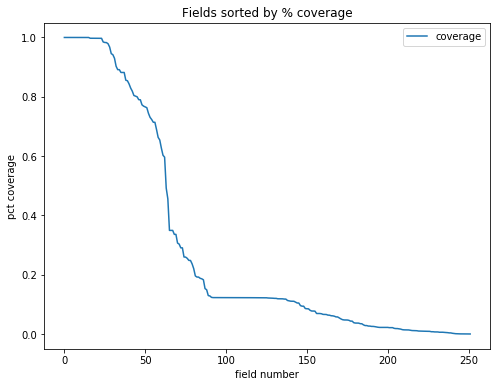

In [170]:
plt.figure(figsize=(8,6))
plt.plot(df['pct_files'].sort_values(ascending=False).values, label='coverage')
plt.title('Fields sorted by % coverage')
plt.xlabel('field number')
plt.ylabel('pct coverage')
plt.legend()
plt.show()

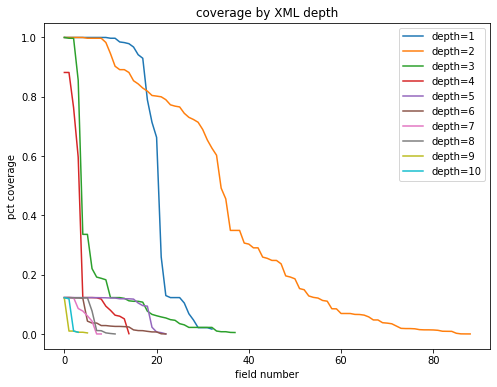

In [171]:
plt.figure(figsize=(8, 6))
plt.title('coverage by XML depth')
for cur_lvl in sorted(df['level'].unique()):
    sub_df = df[df['level'] == cur_lvl]
    plt.plot(sub_df['pct_files'].sort_values(ascending=False).values, label='depth='+str(cur_lvl))
plt.legend()
plt.xlabel('field number')
plt.ylabel('pct coverage')
plt.show()

In [172]:
# Memory Usage?
tot_size = sys.getsizeof(node2file)
for k, v in node2file.items():
    tot_size += sys.getsizeof(v)
    
tot_size / 1024 / 1024  # in MB

188.66703033447266

## Sampling Data Text

In [173]:
def sample_node_text(node, node2file, n=10, apply_fn=None, include_fn=False):
    """
    provided a node string and a node2file map, sample the texts in the raw files
    returns either a list or a dict depending on the include_fn parameter
    :param node: string rep of a node
    :param node2file: pre-crawled dict of node string -> files that contain the node
    :param n: number of samples to return
    :param apply_fn: applys a function to each sampled text
    :param include_fn: if true, returns a dict of filename -> field text instead
    """
    all_files = node2file[node]
    tot_files = len(all_files)
    
    if tot_files < n:
        print("only %s files with this node were found, returning all of them" % tot_files)
        n = tot_files
        
    chosen_files = random.choices(all_files, k=n)
    if include_fn:
        return dict(zip(chosen_files, get_field_from_files(node, chosen_files, apply_fn)))
    else:
        return get_field_from_files(node, chosen_files, apply_fn)
    
def get_field_from_files(node, chosen_files, apply_fn=None):
    """
    loads each file and attempts to extract the node from that file, returns the text from that file
    with an optional apply_fn to apply to the text
    :param node: string representation of a node
    :param list_files: list of file locations
    :param apply_fn: applys a transformation function to each sampled text
    """
    rt_arr = []
    for cur_file in chosen_files:
        raw_text = extract_text_from_file(node, cur_file)
        if apply_fn is None:
            rt_arr.append(raw_text)
        else:
            rt_arr.append(apply_fn(raw_text))
    return rt_arr

def extract_text_from_file(node, cur_file, extract_all=False):
    """
    attempts to extract the text from a node, otherwise returns an error representation string
    :param node: string representation of a node
    :param cur_file: string path of the file to load
    :param extract_all: if true, extracts the list of all text belonging to matching node, else pick random 1
    """
    try:
        tree = ET.parse(cur_file)
        root = tree.getroot()
        all_nodes = root.findall(node)
              
        if extract_all:
            all_text = []
            for cur_node in all_nodes:
                all_text.append(cur_node.text)
            return all_text
        else:
            return random.choice(all_nodes).text
        
        return raw_text
    except Exception:
        print("ERROR: node %s was not found in file %s" % (node, cur_file))
        pass
    

In [174]:
# just the node text
cur_node = './brief_title'
sample_text = sample_node_text(cur_node, node2file, 5, include_fn=False)
sample_text

['Comparison of Pre-hospital and In-hospital Iv-tPA Stroke Treatment',
 'Phase I Study of BCD-145 (Anti-CTLA-4) in Patients With Unresectable/Metastatic Melanoma',
 'Preoperative Resistance Training in Patients Scheduled for Total Hip Arthroplasty',
 'Congenital Heart Disease GEnetic NEtwork Study (CHD GENES)',
 'Urinary Neutrophil Gelatinase-Associated Lipocalin (uNGAL) in Invasive Cardiology']

In [175]:
# as a dict between file path and node text
cur_node = './brief_title'
sample_text = sample_node_text(cur_node, node2file, 5, include_fn=True)
sample_text

{'../raw_data/all/NCT0198xxxx/NCT01988922.xml': 'CYP2B6 Polymorphisms in Ketamine',
 '../raw_data/all/NCT0031xxxx/NCT00313833.xml': 'Safety and Effectiveness of Buprenorphine Transdermal System in Elderly Subjects With Chronic Pain: Pilot Study.',
 '../raw_data/all/NCT0178xxxx/NCT01788566.xml': 'A Study of Gemcitabine-Cisplatin Chemotherapy Plus Necitumumab in the First-Line Treatment of Participants With Squamous Lung Cancer',
 '../raw_data/all/NCT0045xxxx/NCT00456144.xml': 'Prospective Observation Study of Insulin Sensitivity During and After Gonadotropin Releasing Hormone Agonist Therapy for Prostate Cancer',
 '../raw_data/all/NCT0027xxxx/NCT00279721.xml': 'Phase II Study of IMRT With SIB as Adjuvant Treatment for High Risk Resected Well-differentiated Thyroid Cancer.'}

In [162]:
res_dict = {}
n_samples = 5

for cur_node in tqdm(node2file.keys()):
    sample_text = sample_node_text(cur_node, node2file, n_samples)
    res_dict[cur_node] = dict(zip(['ex' + str(x + 1) for x in range(0, len(sample_text))], sample_text))
    

In [163]:
df_res = pd.DataFrame(res_dict).T
df_res.index.name = 'node'
df_res.head()

,ex1,ex2,ex3,ex4,ex5
node,,,,,
./required_header/download_date,ClinicalTrials.gov processed this data on Sept...,ClinicalTrials.gov processed this data on Sept...,ClinicalTrials.gov processed this data on Sept...,ClinicalTrials.gov processed this data on Sept...,ClinicalTrials.gov processed this data on Sept...
./required_header/link_text,Link to the current ClinicalTrials.gov record.,Link to the current ClinicalTrials.gov record.,Link to the current ClinicalTrials.gov record.,Link to the current ClinicalTrials.gov record.,Link to the current ClinicalTrials.gov record.
./required_header/url,https://clinicaltrials.gov/show/NCT01575444,https://clinicaltrials.gov/show/NCT02491242,https://clinicaltrials.gov/show/NCT02307513,https://clinicaltrials.gov/show/NCT03993132,https://clinicaltrials.gov/show/NCT03392870
./id_info/org_study_id,CLEVER-2011,2017-08-124-C,940597,R01AT001146-01,Rad 2:5:1
./id_info/secondary_id,CDR0000398140,2014-000218-67,ID-RCB 2007-A01326-47,SPARROW-I071-341-03,E-6200


In [176]:
dfj = df.join(df_res)

In [178]:
# saving
dfj.to_csv('rf_data/summary.csv')

In [179]:
# loading
dfj = pd.read_csv('rf_data/summary.csv', index_col='node')

# Let's crawl all of the files and summarize the values in the fields

here we can use our node2file_sample first to figure out which fields have duplicate text so we don't crawl every single file

after we have identified the fields where there is duplicate text, we crawl all of the files to get the distribution

In [204]:
sum_df_dict = {}
for node, all_filespaths in tqdm(node2file_sample.items()):
    print("processing %s" % node)
    cur_text_dict = {}
    for fp in tqdm(all_filespaths):
        all_raw_texts = extract_text_from_file(node, fp, extract_all=True)
        
        for raw_text in all_raw_texts:
            if raw_text in cur_text_dict.keys():
                cur_text_dict[raw_text] += 1 
            else:
                cur_text_dict[raw_text] = 1 
            
    cur_df = pd.DataFrame(cur_text_dict, index=['count']).T.sort_values('count', ascending=False)
    cur_df.index.name = 'text'
    sum_df_dict[node] = cur_df

processing ./required_header/download_date


processing ./required_header/link_text


processing ./required_header/url


processing ./id_info/org_study_id


processing ./id_info/nct_id


processing ./brief_title


processing ./official_title


processing ./sponsors/lead_sponsor/agency


processing ./sponsors/lead_sponsor/agency_class


processing ./sponsors/collaborator/agency


processing ./sponsors/collaborator/agency_class


processing ./source


processing ./oversight_info/has_dmc


processing ./oversight_info/is_fda_regulated_drug


processing ./oversight_info/is_fda_regulated_device


processing ./brief_summary/textblock


processing ./overall_status


processing ./start_date


processing ./completion_date


processing ./primary_completion_date


processing ./study_type


processing ./has_expanded_access


processing ./study_design_info/observational_model


processing ./study_design_info/time_perspective


processing ./primary_outcome/measure


processing ./primary_outcome/time_frame


processing ./primary_outcome/description


processing ./secondary_outcome/measure


processing ./secondary_outcome/time_frame


processing ./secondary_outcome/description


processing ./enrollment


processing ./condition


processing ./intervention/intervention_type


processing ./intervention/intervention_name


processing ./intervention/description


processing ./eligibility/study_pop/textblock


processing ./eligibility/sampling_method


processing ./eligibility/criteria/textblock


processing ./eligibility/gender


processing ./eligibility/minimum_age


processing ./eligibility/maximum_age


processing ./eligibility/healthy_volunteers


processing ./overall_official/last_name


processing ./overall_official/role


processing ./overall_official/affiliation


processing ./overall_contact/last_name


processing ./overall_contact/phone


processing ./overall_contact/email


processing ./location/facility/name


processing ./location/facility/address/city


processing ./location/facility/address/zip


processing ./location/facility/address/country


processing ./location/status


processing ./location/contact/last_name


processing ./location/contact/phone


processing ./location/contact/email


processing ./location/contact_backup/last_name


processing ./location/contact_backup/phone


processing ./location/contact_backup/email


processing ./location_countries/country


processing ./verification_date


processing ./study_first_submitted


processing ./study_first_submitted_qc


processing ./study_first_posted


processing ./last_update_submitted


processing ./last_update_submitted_qc


processing ./last_update_posted


processing ./responsible_party/responsible_party_type


processing ./keyword


processing ./condition_browse/mesh_term


processing ./id_info/secondary_id


processing ./phase


processing ./study_design_info/allocation


processing ./study_design_info/intervention_model


processing ./study_design_info/primary_purpose


processing ./study_design_info/masking


processing ./number_of_arms


processing ./arm_group/arm_group_label


processing ./arm_group/arm_group_type


processing ./intervention/arm_group_label


processing ./patient_data/sharing_ipd


processing ./patient_data/ipd_description


processing ./detailed_description/textblock


processing ./biospec_retention


processing ./biospec_descr/textblock


processing ./location/facility/address/state


processing ./responsible_party/investigator_affiliation


processing ./responsible_party/investigator_full_name


processing ./responsible_party/investigator_title


processing ./intervention_browse/mesh_term


processing ./acronym


processing ./arm_group/description


processing ./intervention/other_name


processing ./removed_countries/country


processing ./why_stopped


processing ./other_outcome/measure


processing ./other_outcome/time_frame


processing ./other_outcome/description


processing ./results_first_submitted


processing ./results_first_submitted_qc


processing ./results_first_posted


processing ./clinical_results/participant_flow/group_list/group/title


processing ./clinical_results/participant_flow/group_list/group/description


processing ./clinical_results/participant_flow/period_list/period/title


processing ./clinical_results/participant_flow/period_list/period/milestone_list/milestone/title


processing ./clinical_results/participant_flow/period_list/period/milestone_list/milestone/participants_list/participants


processing ./clinical_results/baseline/group_list/group/title


processing ./clinical_results/baseline/group_list/group/description


processing ./clinical_results/baseline/analyzed_list/analyzed/units


processing ./clinical_results/baseline/analyzed_list/analyzed/scope


processing ./clinical_results/baseline/analyzed_list/analyzed/count_list/count


processing ./clinical_results/baseline/measure_list/measure/title


processing ./clinical_results/baseline/measure_list/measure/units


processing ./clinical_results/baseline/measure_list/measure/param


processing ./clinical_results/baseline/measure_list/measure/dispersion


processing ./clinical_results/baseline/measure_list/measure/class_list/class/category_list/category/measurement_list/measurement


processing ./clinical_results/baseline/measure_list/measure/class_list/class/category_list/category/title


processing ./clinical_results/baseline/measure_list/measure/class_list/class/title


processing ./clinical_results/outcome_list/outcome/type


processing ./clinical_results/outcome_list/outcome/title


processing ./clinical_results/outcome_list/outcome/time_frame


processing ./clinical_results/outcome_list/outcome/group_list/group/title


processing ./clinical_results/outcome_list/outcome/group_list/group/description


processing ./clinical_results/outcome_list/outcome/measure/title


processing ./clinical_results/outcome_list/outcome/measure/units


processing ./clinical_results/outcome_list/outcome/measure/param


processing ./clinical_results/outcome_list/outcome/measure/analyzed_list/analyzed/units


processing ./clinical_results/outcome_list/outcome/measure/analyzed_list/analyzed/scope


processing ./clinical_results/outcome_list/outcome/measure/analyzed_list/analyzed/count_list/count


processing ./clinical_results/outcome_list/outcome/measure/class_list/class/category_list/category/measurement_list/measurement


processing ./clinical_results/outcome_list/outcome/description


processing ./clinical_results/outcome_list/outcome/population


processing ./clinical_results/outcome_list/outcome/measure/description


processing ./clinical_results/outcome_list/outcome/measure/population


processing ./clinical_results/reported_events/group_list/group/title


processing ./clinical_results/reported_events/group_list/group/description


processing ./clinical_results/reported_events/serious_events/category_list/category/title


processing ./clinical_results/reported_events/serious_events/category_list/category/event_list/event/sub_title


processing ./clinical_results/reported_events/serious_events/category_list/category/event_list/event/counts


processing ./clinical_results/reported_events/other_events/frequency_threshold


processing ./clinical_results/reported_events/other_events/category_list/category/title


processing ./clinical_results/reported_events/other_events/category_list/category/event_list/event/sub_title


processing ./clinical_results/reported_events/other_events/category_list/category/event_list/event/counts


processing ./clinical_results/certain_agreements/pi_employee


processing ./clinical_results/certain_agreements/restrictive_agreement


processing ./clinical_results/point_of_contact/name_or_title


processing ./clinical_results/point_of_contact/organization


processing ./clinical_results/point_of_contact/phone


processing ./clinical_results/point_of_contact/email


processing ./reference/citation


processing ./reference/PMID


processing ./results_reference/citation


processing ./results_reference/PMID


processing ./number_of_groups


processing ./link/url


processing ./link/description


processing ./last_known_status


processing ./target_duration


processing ./location/contact/phone_ext


processing ./study_docs/study_doc/doc_id


processing ./study_docs/study_doc/doc_type


processing ./study_docs/study_doc/doc_url


processing ./study_docs/study_doc/doc_comment


processing ./clinical_results/participant_flow/pre_assignment_details


processing ./clinical_results/participant_flow/period_list/period/drop_withdraw_reason_list/drop_withdraw_reason/title


processing ./clinical_results/participant_flow/period_list/period/drop_withdraw_reason_list/drop_withdraw_reason/participants_list/participants


processing ./clinical_results/outcome_list/outcome/measure/class_list/class/title


processing ./clinical_results/outcome_list/outcome/measure/dispersion


processing ./clinical_results/reported_events/time_frame


processing ./study_design_info/intervention_model_description


processing ./provided_document_section/provided_document/document_type


processing ./provided_document_section/provided_document/document_has_protocol


processing ./provided_document_section/provided_document/document_has_icf


processing ./provided_document_section/provided_document/document_has_sap


processing ./provided_document_section/provided_document/document_date


processing ./provided_document_section/provided_document/document_url


processing ./id_info/nct_alias


processing ./overall_contact_backup/last_name


processing ./overall_contact_backup/phone


processing ./overall_contact_backup/email


processing ./oversight_info/is_us_export


processing ./location/investigator/last_name


processing ./location/investigator/role


processing ./clinical_results/baseline/measure_list/measure/description


processing ./clinical_results/reported_events/desc


processing ./study_design_info/masking_description


processing ./pending_results/submitted


processing ./pending_results/returned


processing ./eligibility/gender_based


processing ./eligibility/gender_description


processing ./location/contact_backup/phone_ext


processing ./clinical_results/participant_flow/recruitment_details


processing ./clinical_results/reported_events/serious_events/default_vocab


processing ./clinical_results/reported_events/serious_events/default_assessment


processing ./clinical_results/reported_events/other_events/default_vocab


processing ./clinical_results/reported_events/other_events/default_assessment


processing ./overall_contact/phone_ext


processing ./overall_contact_backup/phone_ext


processing ./responsible_party/name_title


processing ./responsible_party/organization


processing ./oversight_info/is_unapproved_device


processing ./oversight_info/is_ppsd


processing ./clinical_results/baseline/measure_list/measure/population


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/group_id_list/group_id


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/non_inferiority_type


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/p_value


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/method


processing ./clinical_results/limitations_and_caveats


processing ./clinical_results/baseline/population


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/method_desc


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/param_type


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/param_value


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/dispersion_type


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/dispersion_value


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/ci_percent


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/ci_n_sides


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/ci_lower_limit


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/ci_upper_limit


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/p_value_desc


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/estimate_desc


processing ./clinical_results/reported_events/other_events/category_list/category/event_list/event/description


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/groups_desc


processing ./disposition_first_submitted


processing ./disposition_first_submitted_qc


processing ./disposition_first_posted


processing ./patient_data/ipd_info_type


processing ./patient_data/ipd_time_frame


processing ./patient_data/ipd_access_criteria


processing ./patient_data/ipd_url


processing ./clinical_results/reported_events/serious_events/category_list/category/event_list/event/description


processing ./clinical_results/reported_events/other_events/category_list/category/event_list/event/assessment


processing ./pending_results/submission_canceled


processing ./clinical_results/outcome_list/outcome/measure/class_list/class/analyzed_list/analyzed/units


processing ./clinical_results/outcome_list/outcome/measure/class_list/class/analyzed_list/analyzed/scope


processing ./clinical_results/outcome_list/outcome/measure/class_list/class/analyzed_list/analyzed/count_list/count


processing ./clinical_results/baseline/measure_list/measure/class_list/class/analyzed_list/analyzed/units


processing ./clinical_results/baseline/measure_list/measure/class_list/class/analyzed_list/analyzed/scope


processing ./clinical_results/baseline/measure_list/measure/class_list/class/analyzed_list/analyzed/count_list/count


processing ./clinical_results/outcome_list/outcome/analysis_list/analysis/non_inferiority_desc


processing ./clinical_results/outcome_list/outcome/measure/class_list/class/category_list/category/title


processing ./clinical_results/outcome_list/outcome/measure/units_analyzed


processing ./clinical_results/outcome_list/outcome/posting_date


In [215]:
# saving
pickle.dump(sum_df_dict, open('rf_data/summary_dfs.p', 'wb'))

In [216]:
# loading
sum_df_dict = pickle.load(open('rf_data/summary_dfs.p', 'rb'))

### determine which to crawl full dataset

Let's only crawl the full dataset for nodes such 80% of the density is in the first 20 nodes

In [251]:
to_crawl = []
for node, df in sum_df_dict.items():
    node_density_at_20 = (df / df.sum()).cumsum()[:20]['count'].values[-1]
    if node_density_at_20 > 0.8 and len(df) > 1:
        to_crawl.append(node)

In [252]:
len(to_crawl)

91

In [ ]:
g